# Adversarial Robustness with Error Correcting Codes (and Hinge Loss)
## (Never use Softmax again)

In this example we will show how using error correcting codes as a model output can drastically reduce model overfitting while simultaneously increasing model robustness against adversarial attacks. In other words, why you should never use a softmax layer again. This is slightly more complicated than the our other [ECC](../ecc/ecc.ipynb) apphub example, but it allows for more accurate final probability estimates (the FE Hadamard network layer results in probability smoothing which prevents the network from ever being 100% confident in a class choice). The usefulness of error correcting codes was first publicized by the US Army in a [2019 Neurips Paper](https://papers.nips.cc/paper/9070-error-correcting-output-codes-improve-probability-estimation-and-adversarial-robustness-of-deep-neural-networks.pdf). For background on adversarial attacks, and on the attack type we will be demonstrating here, check out our [FGSM](../fgsm/fgsm.ipynb) apphub example. Note that in this apphub we will not be training against adversarial samples, but only performing adversarial attacks during evaluation to see how different models fair against them.

## Imports

In [1]:
import tempfile

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.univariate import Hadamard, Normalize
from fastestimator.op.tensorop import UnHadamard
from fastestimator.op.tensorop.gradient import FGSM, Watch
from fastestimator.op.tensorop.loss import CrossEntropy, Hinge
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import EarlyStopping
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

In [2]:
# training parameters
epsilon=0.04  # The strength of the adversarial attack
epochs=60
batch_size=50
log_steps=500
train_steps_per_epoch=None
eval_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

## Getting the Data
For these experiments we will be using the ciFAIR10 Dataset (like cifar10, but with duplicate testing data replaced)

In [3]:
train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[
        Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
        Hadamard(inputs="y", outputs="y_code", n_classes=10)
        ])

## Defining Estimators
In this apphub we will be comparing a baseline model against two models using hinge loss to enable training with error correcting codes. The setting up the hinge loss models requires a few extra Ops along the way.

In [4]:
def get_baseline_estimator(model):
    network = fe.Network(ops=[
        Watch(inputs="x", mode=('eval', 'test')),
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="base_ce"),
        UpdateOp(model=model, loss_name="base_ce"),
        FGSM(data="x", loss="base_ce", outputs="x_adverse", epsilon=epsilon, mode=('eval', 'test')),
        ModelOp(model=model, inputs="x_adverse", outputs="y_pred_adv", mode=('eval', 'test')),
        CrossEntropy(inputs=("y_pred_adv", "y"), outputs="adv_ce", mode=('eval', 'test'))
    ])
    traces = [
        Accuracy(true_key="y", pred_key="y_pred", output_name="base_accuracy"),
        Accuracy(true_key="y", pred_key="y_pred_adv", output_name="adversarial_accuracy"),
        BestModelSaver(model=model, save_dir=save_dir, metric="base_ce", save_best_mode="min", load_best_final=True),
        EarlyStopping(monitor="base_ce", patience=10)
    ]
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces,
                             log_steps=log_steps,
                             train_steps_per_epoch=train_steps_per_epoch,
                             eval_steps_per_epoch=eval_steps_per_epoch,
                             monitor_names=["adv_ce"])
    return estimator

In [5]:
def get_hinge_estimator(model):
    network = fe.Network(ops=[
        Watch(inputs="x", mode=('eval', 'test')),
        ModelOp(model=model, inputs="x", outputs="y_pred_code"),
        Hinge(inputs=("y_pred_code", "y_code"), outputs="base_hinge"),
        UpdateOp(model=model, loss_name="base_hinge"),
        UnHadamard(inputs="y_pred_code", outputs="y_pred", n_classes=10, mode=('eval', 'test')),
        # The adversarial attack:
        FGSM(data="x", loss="base_hinge", outputs="x_adverse_hinge", epsilon=epsilon, mode=('eval', 'test')),
        ModelOp(model=model, inputs="x_adverse_hinge", outputs="y_pred_adv_hinge_code", mode=('eval', 'test')),
        Hinge(inputs=("y_pred_adv_hinge_code", "y_code"), outputs="adv_hinge", mode=('eval', 'test')),
        UnHadamard(inputs="y_pred_adv_hinge_code", outputs="y_pred_adv_hinge", n_classes=10, mode=('eval', 'test')),
    ])
    traces = [
        Accuracy(true_key="y", pred_key="y_pred", output_name="base_accuracy"),
        Accuracy(true_key="y", pred_key="y_pred_adv_hinge", output_name="adversarial_accuracy"),
        BestModelSaver(model=model, save_dir=save_dir, metric="base_hinge", save_best_mode="min", load_best_final=True),
        EarlyStopping(monitor="base_hinge", patience=10)
    ]
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces,
                             log_steps=log_steps,
                             train_steps_per_epoch=train_steps_per_epoch,
                             eval_steps_per_epoch=eval_steps_per_epoch,
                             monitor_names=["adv_hinge"])
    return estimator

## The Models
### 1 - A LeNet model with Softmax

In [6]:
softmax_model = fe.build(model_fn=lambda:LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam", model_name='softmax')

Metal device set to: Apple M1 Max


2022-02-22 16:10:08.353829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 16:10:08.353960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 2 - A LeNet model with Error Correcting Codes

In [7]:
def EccLeNet(input_shape=(32, 32, 3), code_length=16):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(code_length, activation='tanh'))  # Note that this is the only difference between this model and the FE LeNet implementation
    return model

In [8]:
ecc_model = fe.build(model_fn=EccLeNet, optimizer_fn="adam", model_name='ecc')

### 3 - A LeNet model using ECC and multiple feature heads
While it is common practice to follow the feature extraction layers of convolution networks with several fully connected layers in order to perform classification, this can lead to the final logits being interdependent which can actually reduce the robustness of the network. One way around this is to divide your classification layers into multiple smaller independent units:

In [9]:
def HydraEccLeNet(input_shape=(32, 32, 3), code_length=16):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    flat = Flatten()(conv3)
    # Create multiple heads
    n_heads = 4
    heads = [Dense(16, activation='relu')(flat) for _ in range(n_heads)]
    heads2 = [Dense(code_length // n_heads, activation='tanh')(head) for head in heads]
    outputs = Concatenate()(heads2)
    return Model(inputs=inputs, outputs=outputs)

In [10]:
hydra_model = fe.build(model_fn=HydraEccLeNet, optimizer_fn="adam", model_name='hydra_ecc')

## The Experiments
Let's get Estimators for each of these models and compare them:

In [11]:
softmax_estimator = get_baseline_estimator(softmax_model)
ecc_estimator = get_hinge_estimator(ecc_model)
hydra_estimator = get_hinge_estimator(hydra_model)

2022-02-22 16:10:08.723377: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [12]:
softmax_estimator.fit('Softmax')
softmax_results = softmax_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'y_code' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.
FastEstimator-Start: step: 1; logging_interval: 500; num_device: 0;
FastEstimator-Train: step: 1; base_ce: 2.3674514;
FastEstimator-Train: step: 500; base_ce: 1.2706153; steps/sec: 121.6;
FastEstimator-Train: step: 1000; base_ce: 1.2631996; steps/sec: 120.73;
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 8.96 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/d

In [13]:
ecc_estimator.fit('ECC')
ecc_results = ecc_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'y' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.
FastEstimator-Start: step: 1; logging_interval: 500; num_device: 0;
FastEstimator-Train: step: 1; base_hinge: 1.0171145;
FastEstimator-Train: step: 500; base_hinge: 0.64865017; steps/sec: 122.93;
FastEstimator-Train: step: 1000; base_hinge: 0.4624069; steps/sec: 122.11;
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 8.59 sec;
FastEstimator-BestModelSaver: Saved model to /var/folder

In [14]:
hydra_estimator.fit('Hydra')
hydra_results = hydra_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 500; num_device: 0;
FastEstimator-Train: step: 1; base_hinge: 0.99642134;
FastEstimator-Train: step: 500; base_hinge: 0.644743; steps/sec: 98.9;
FastEstimator-Train: step: 1000; base_hinge: 0.59315056; steps/sec: 100.64;
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 10.85 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpmzmwqwmg/hydra_ecc_best_base_hinge.h5
FastEstimator-Eval: step: 1000; epoch: 1; adv_hinge: 0.7489558; adversarial_accuracy: 0.259

## Comparing the Results

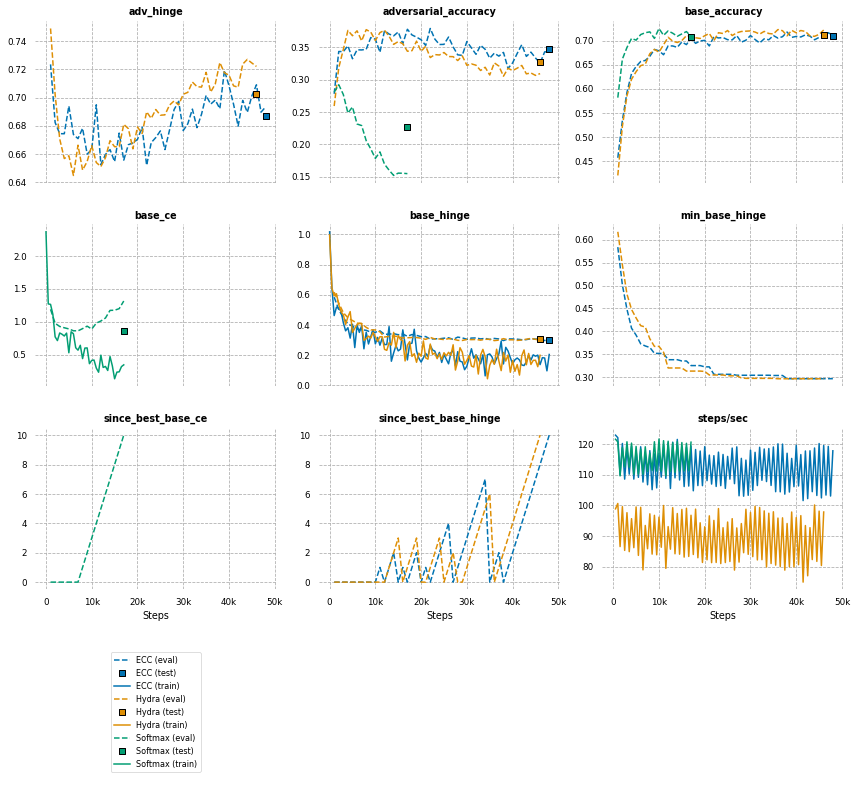

In [15]:
logs = visualize_logs(experiments=[softmax_results, ecc_results, hydra_results], ignore_metrics={'ecc_lr', 'hydra_ecc_lr', 'softmax_lr', 'logging_interval', 'num_device', 'epoch_time', 'min_base_ce', 'adv_ce', 'total_time'})

As you can see, the conventional network using softmax to convert logits to class probabilities actually gets more and more vulnerable to adversarial attacks as training progresses. It also quickly overfits to the data, reaching an optimal performance around epoch 7. By switching the output layer of the model to generate an error correcting code and training with hinge loss, the model is able to train almost 6 times longer before reaching peak conventional accuracy. Moreover, the adversarial performance of the network continues to improve even after the main training runs out. This is significantly better performance than networks trained specifically to combat this attack, shown in the [FGSM](../fgsm/fgsm.ipynb) notebook. It can also be seen that there is no additional cost to training using ECC as opposed to softmax in terms of steps/sec. This is a big benefit over FGSM, where the training time for each step is doubled. With these benefits in mind, you may want to consider never using softmax again.